# LeNet

This notebook trains the LeNet-5 neural network on the MNIST database.

#### Imports

In [771]:
import importlib
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import re
import time
from typing import Any, Dict
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

from models.torch_lenet import TorchLeNet
import src.data.data as data
import src.misc.adversarial as adversarial

importlib.reload(data)
importlib.reload(adversarial)

SEED = 12

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

### Training

The following attributes can be changed via flags:

- `_framework`: Only `"torch"` is currently supported
- `_val_split`: Fraction of the train data to split into a withheld validation set
- `_rotation_degrees`: Sets the maximum degrees of random rotation applied to the train data
- `_crop_padding`: Sets the maximum pixels of random padding applied to the train data
- `_duplicate_with_augment`: If True, duplicates train images when appling data augmentation (crop, rotation)
- `_init`: Weight initialization method
- `_optimizer`: Weight optimization method
- `_activation`: Non-linear activation function used in the model
- `_lr`: Learning rate
- `_seed`: Random seed

The filename/path where a model is saved describes all these attributes.

In [760]:
_framework = "torch"  #@param ["torch", "jax"]
_val_split = 0.1  #@param
_rotation_degrees = 0  #@param
_crop_padding = 0  #@param
_duplicate_with_augment = False  # Adds --duplicate_with_augment flag
_init = "kaiming"  #@param ["orthogonal", "kaiming", "xavier"]
_optimizer = "adamw"  #@param ["sgd", "adam", "adamw"]
_activation = "relu"  #@param ["relu", "tanh", "sigmoid"]
_lr = 3e-4  #@param
_seed = SEED  #@param


model_name = f'src/models/ckpts/lenet_{_framework}_{_val_split}_{_rotation_degrees}_{_crop_padding}_{_duplicate_with_augment}_{_init}_{_optimizer}_{_activation}_{_lr}_{_seed}'
model_path = model_name + '.pth'
print(model_path)

src/models/ckpts/lenet_torch_0.1_0_0_False_kaiming_adamw_relu_0.0003_12.pth


In [677]:
# Run this to train a model!
! python src/train.py --framework={_framework} \
    --val_split={_val_split} \
    --rotation_degrees={_rotation_degrees} \
    --crop_padding={_crop_padding} \
    {"--duplicate_with_augment" if _duplicate_with_augment else ""} \
    --init={_init} \
    --optimizer={_optimizer} \
    --activation={_activation} \
    --lr={_lr} \
    --seed={_seed}

---------------------------------------------
Framework:                  torch
Validation Split:           0.1
Rotation Degrees:           0
Crop Padding:               0
Duplicate with Augment:     False
Init method:                kaiming
Optimizer:                  adamw
Activation:                 relu
Learning Rate:              0.0003
Random Seed:                12
---------------------------------------------
Train: Dataset MNIST
    Number of datapoints: 54000

Val: Dataset MNIST
    Number of datapoints: 6000
Test: Dataset MNIST
    Number of datapoints: 10000
    Root location: src/data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[tensor(0.1307)], std=[tensor(0.3081)])
           )

---------------------------------------------
TorchLeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2

### Evaluation

Models are automatically evaluated on the held-out test set after training is done. However, this section can be used to manually evaluate a model on the MNIST test set. In particular, we can examine the images that a model classifies incorrectly, as these images are ambiguous or may be mislabeled.

In [761]:
from models.torch_lenet import TorchLeNet

print(f'Loading model at: {model_path}')

def get_model_params(model_path: str) -> Dict[str, Any]:
    model_params = model_path.replace(".pth", "").split("_")
    assert len(model_params) == 11 or len(model_params) == 12
    
    params_dict = {}
    params_dict["framework"] = model_params[1]
    params_dict["val_split"] = float(model_params[2])
    params_dict["rotation_degrees"] = int(model_params[3])
    params_dict["crop_padding"] = int(model_params[4])
    params_dict["duplicate_with_augment"] = model_params[5]
    params_dict["init"] = model_params[6]
    params_dict["optimizer"] = model_params[7]
    params_dict["activation"] = model_params[8]
    params_dict["lr"] = float(model_params[9])
    params_dict["seed"] = int(model_params[10])
    if len(model_params) == 12:
        params_dict["adversarial_training"] = model_params[11]

    return params_dict
    
# Load model
model_params = get_model_params(model_path)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lenet5 = TorchLeNet(act_fn=model_params["activation"], init=model_params["init"]).to(device)
lenet5.load_state_dict(torch.load(model_path))

# Read training run metadata from JSON
with open(f'{model_name}.json', "r") as f:
    model_metadata = json.load(f)

print(f'Training run metadata: {model_metadata}')

Loading model at: src/models/ckpts/lenet_torch_0.1_0_0_False_kaiming_adamw_relu_0.0003_12.pth
Training run metadata: {'epochs': 19, 'train_time': 454.03160858154297, 'test_accuracy': 0.9865}


In [762]:
train_dataset, test_dataset, val_dataset = data.get_MNIST()
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

lenet5.eval()
test_x, test_y = next(iter(test_loader))   # apply transforms (normalization)
test_x, test_y = test_x.to(device), test_y.to(device)
with torch.no_grad():
    test_logits = lenet5(test_x)
    test_preds = test_logits.argmax(dim=1)
    accuracy = (test_preds == test_y).sum() / len(test_y)

print(f'Test Set Accuracy: {100 * accuracy:.2f}%')

Test Set Accuracy: 98.65%


In [749]:
def plot_errors(model: torch.nn, x, y, logits, split_name, n_cols=10):
    """
    Visualizes examples where the model makes incorrect predictions.
    """
    preds = logits.argmax(dim=1)
    error_idxs = np.where(preds != y)[0]
    error_imgs = [x[i][0].numpy().squeeze() for i in error_idxs]
    
    y_true = y[error_idxs]
    y_pred = preds[error_idxs]
    
    n_images = len(error_idxs)
    n_rows = int(np.ceil(n_images / n_cols))
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 1.5, n_rows * 1.5))
    axes = axes.flatten()
    
    for i, ax in enumerate(axes):
        if i < n_images:
            ax.imshow(error_imgs[i], cmap='gray')
            ax.set_title(f"True: {y_true[i]} Pred: {y_pred[i]}", fontsize=10)
        ax.axis('off')
    
    plt.suptitle(f"Incorrect Predictions on MNIST {split_name} Set ({n_images})", fontsize=20); plt.tight_layout(rect=[0, 0.03, 1, 0.98]); plt.show()

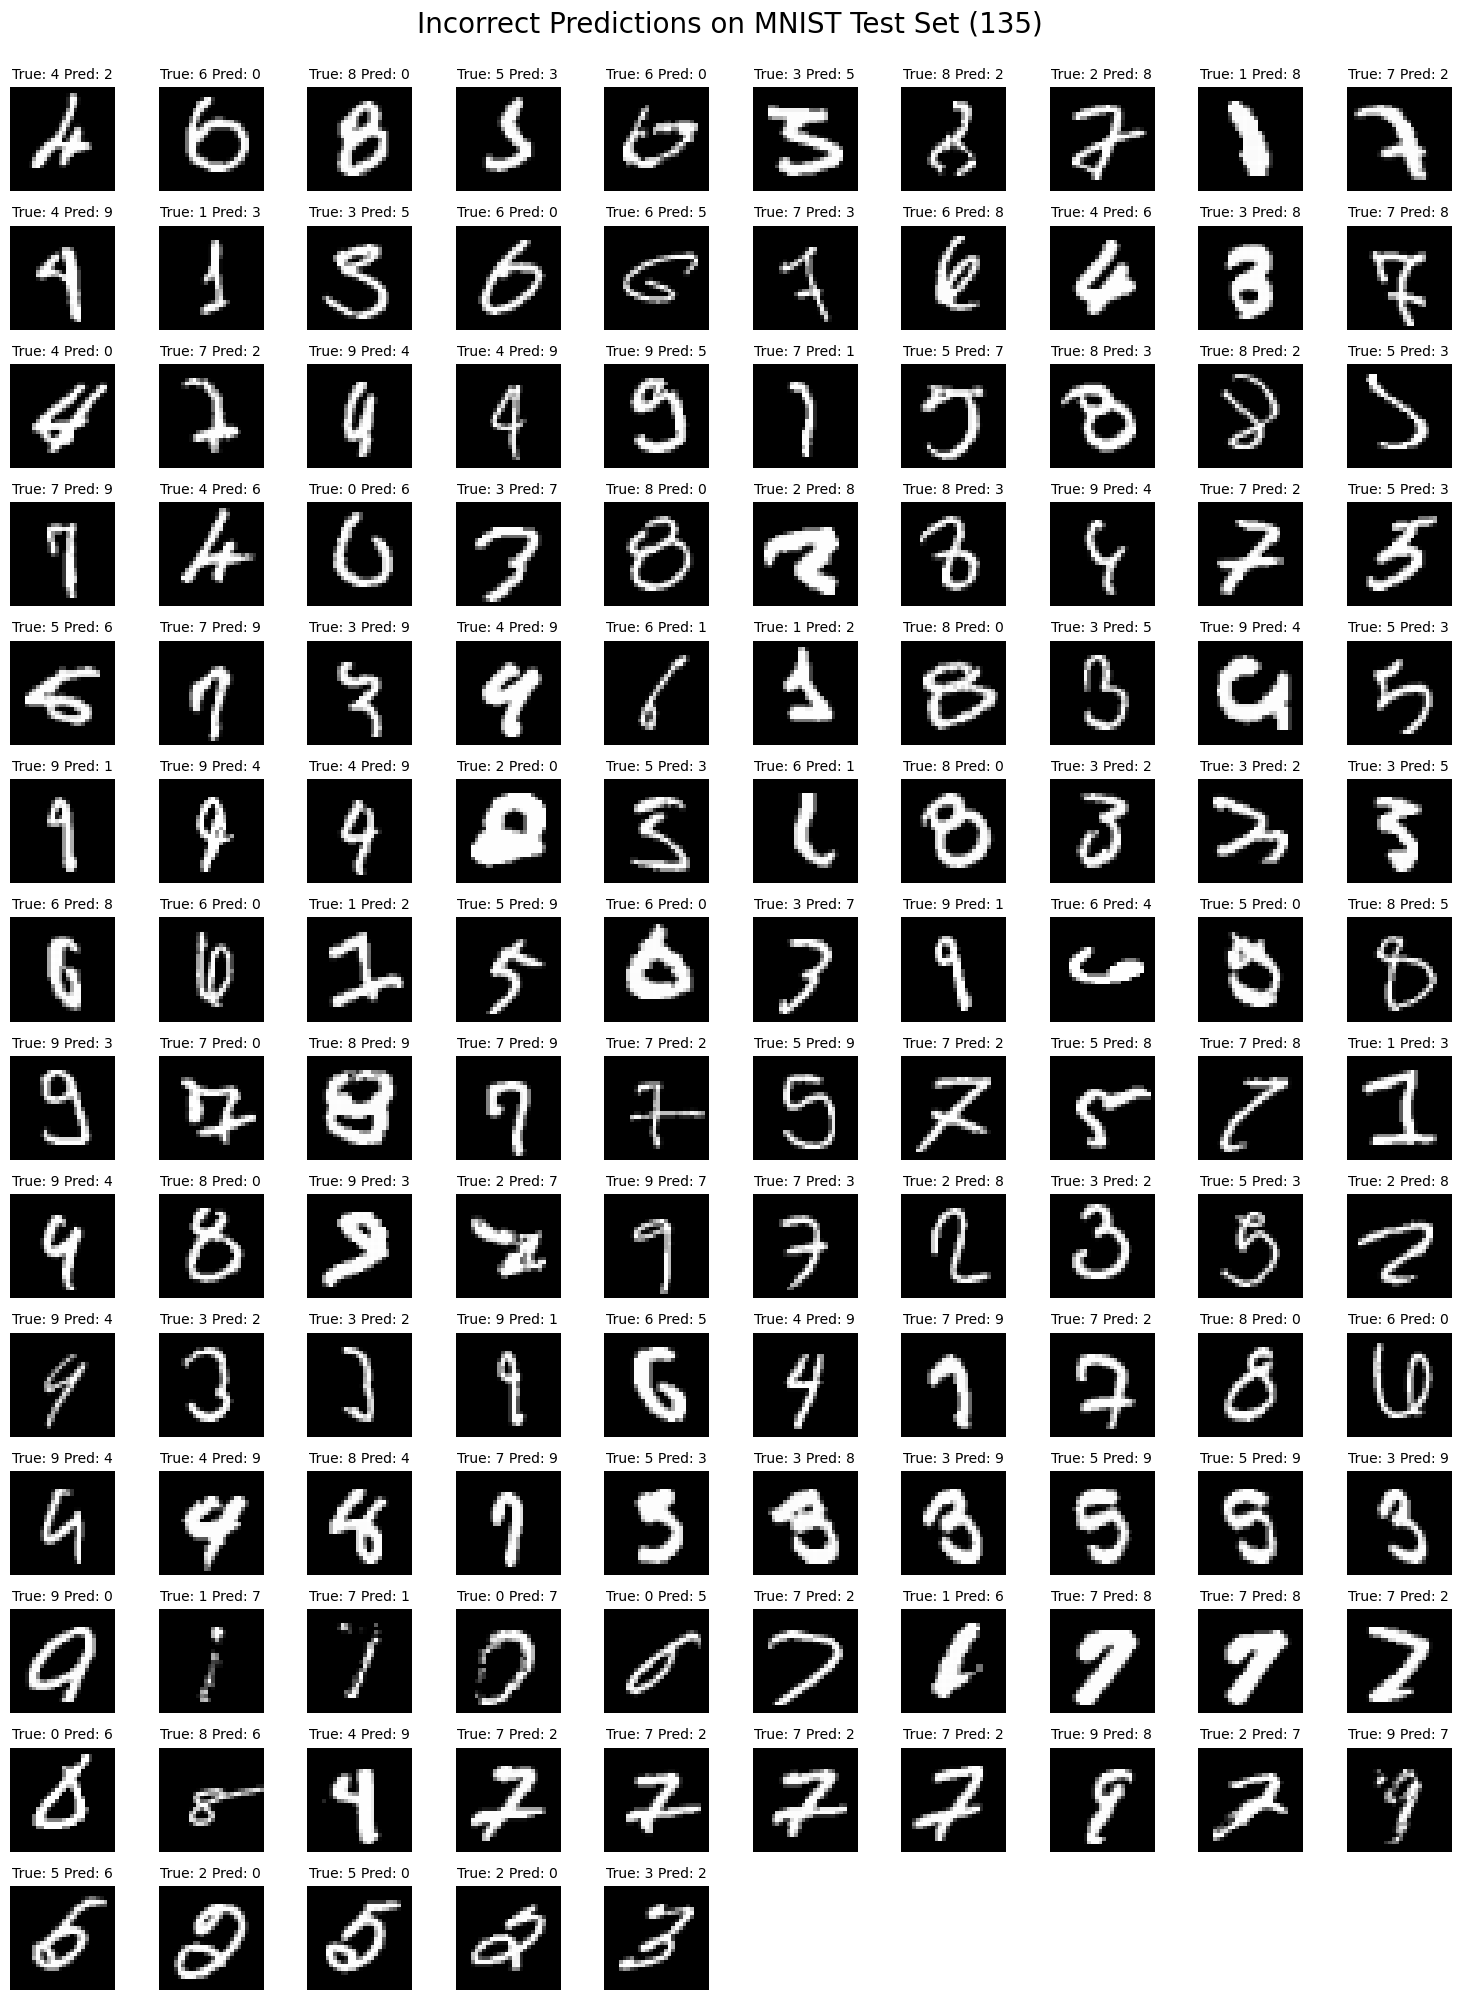

In [746]:
# Examine incorrect predictions on the test set
plot_errors(lenet5, test_x, test_y, test_preds, "Test")

In [ ]:
# Sort by log-probs to find the images the model is most uncertain about

We can also check the training and validation data to see if any examples are clearly mislabeled or poor quality. If most data is of high quality, we can assume our model learns a mostly correct decision boundary, and that incorrectly predicted exampels may be mislabeled.

In [738]:
# Examine incorrect predictions on the train and validation sets
val_loader = DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False)

lenet5.eval()
val_x, val_y = next(iter(val_loader))   # apply transforms (normalization)
val_x, val_y = val_x.to(device), val_y.to(device)
with torch.no_grad():
    val_logits = lenet5(val_x)
    val_preds = val_logits.argmax(dim=1)
    val_accuracy = (val_preds == val_y).sum() / len(val_y)

print(f'Validation Set Accuracy: {100 * val_accuracy:.2f}%')

Validation Set Accuracy: 99.02%


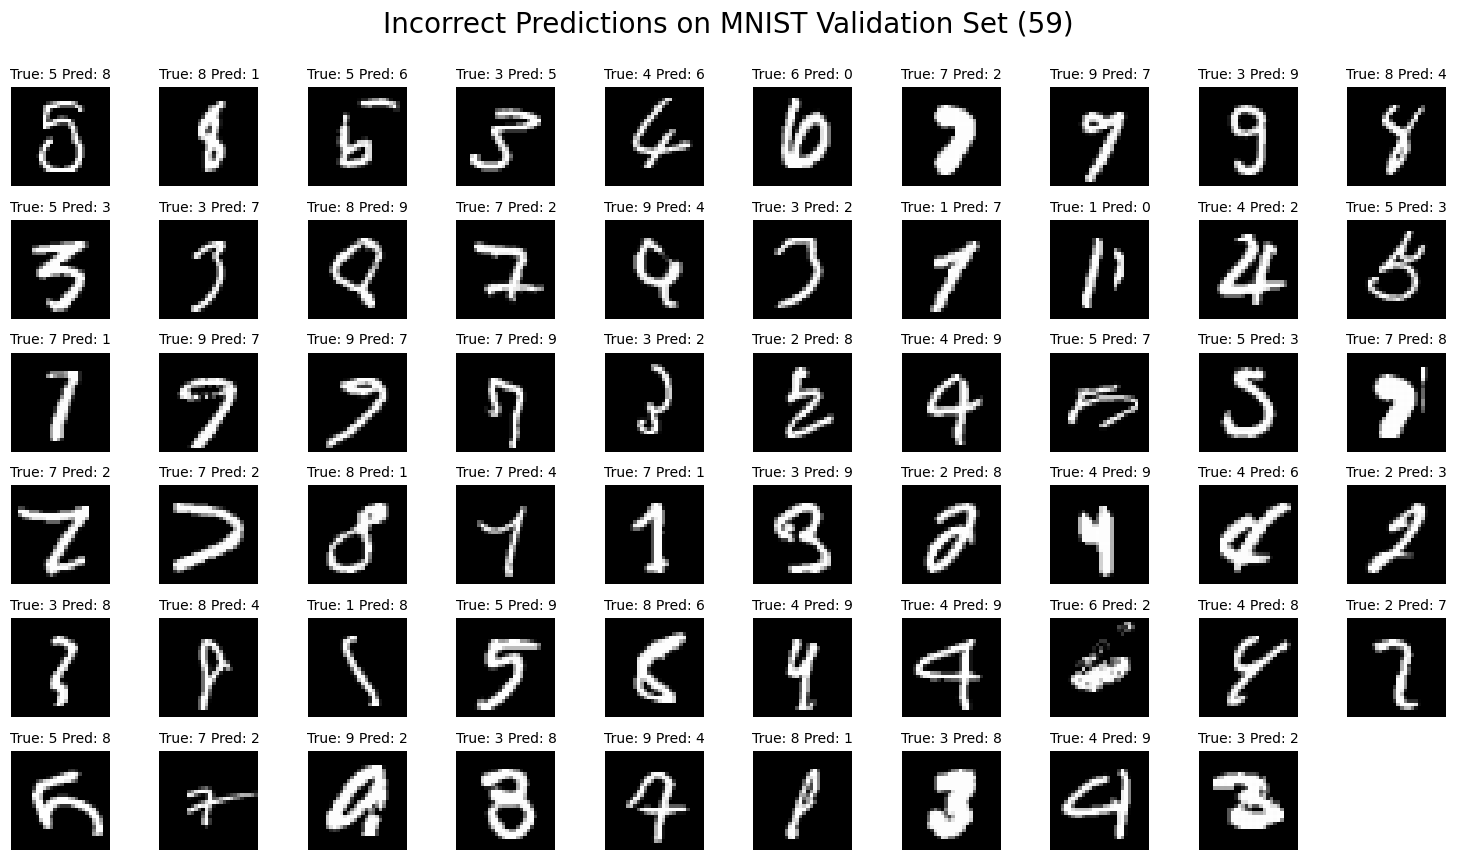

In [747]:
plot_errors(lenet5, val_x, val_y, val_preds, "Validation")

In [743]:
train_loader = DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=False)

lenet5.eval()
train_x, train_y = next(iter(train_loader))   # apply transforms (normalization)
train_x, train_y = train_x.to(device), train_y.to(device)
with torch.no_grad():
    train_logits = lenet5(train_x)
    train_preds = train_logits.argmax(dim=1)
    train_accuracy = (train_preds == train_y).sum() / len(train_y)

print(f'Training Set Accuracy: {100 * train_accuracy:.2f}%')

Training Set Accuracy: 99.03%


In [ ]:
plot_errors(lenet5, train_x, train_y, train_preds, "Train")  # This is a lot of images to render.

### Ablations

We want to identify which aspects of the model's architecture, data, and training contribute to its performance. Some possible variables include:

#### Architecture
- Activation functions
- Parameters (changes to model depth or width)
- Convolution size and stride

#### Data
- Random crop
- Random rotation
- Duplication during augmentation

#### Training
- Optimizer
- Learning Rate
- Weight initialization
- Dropout
- Random seed

In [657]:
# Sweep over parameters for ablation

for _activation in ["relu", "tanh", "sigmoid"]:
    _framework = "torch"  #@param ["torch", "jax"]
    _val_split = 0.1  #@param
    _rotation_degrees = 0  #@param
    _crop_padding = 0  #@param
    _duplicate_with_augment = False  # Adds --duplicate_with_augment flag
    _init = "kaiming"  #@param ["orthogonal", "kaiming", "xavier"]
    _optimizer = "adamw"  #@param ["sgd", "adam", "adamw"]
    #_activation = "relu"  #@param ["relu", "tanh", "sigmoid"]
    _lr = 3e-4  #@param
    _seed = SEED  #@param
    
    
    model_name = f'src/models/ckpts/lenet_{_framework}_{_val_split}_{_rotation_degrees}_{_crop_padding}_{_duplicate_with_augment}_{_init}_{_optimizer}_{_activation}_{_lr}_{_seed}'
    model_path = model_name + '.pth'
    print(model_path)

    if not os.path.exists(model_path):
        ! python src/train.py --framework={_framework} \
            --val_split={_val_split} \
            --rotation_degrees={_rotation_degrees} \
            --crop_padding={_crop_padding} \
            {"--duplicate_with_augment" if _duplicate_with_augment else ""} \
            --init={_init} \
            --optimizer={_optimizer} \
            --activation={_activation} \
            --lr={_lr} \
            --seed={_seed}

src/models/ckpts/lenet_torch_0.1_0_0_False_kaiming_adamw_relu_0.0003_12.pth
src/models/ckpts/lenet_torch_0.1_0_0_False_kaiming_adamw_tanh_0.0003_12.pth
---------------------------------------------
Framework:                  torch
Validation Split:           0.1
Rotation Degrees:           0
Crop Padding:               0
Duplicate with Augment:     False
Init method:                kaiming
Optimizer:                  adamw
Activation:                 tanh
Learning Rate:              0.0003
Random Seed:                12
---------------------------------------------
Train: Dataset MNIST
    Number of datapoints: 54000

Val: Dataset MNIST
    Number of datapoints: 6000
Test: Dataset MNIST
    Number of datapoints: 10000
    Root location: src/data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[tensor(0.1307)], std=[tensor(0.3081)])
           )

---------------------------------------------
TorchLeNet(
  (conv1): Conv2d

#### Learning Rates

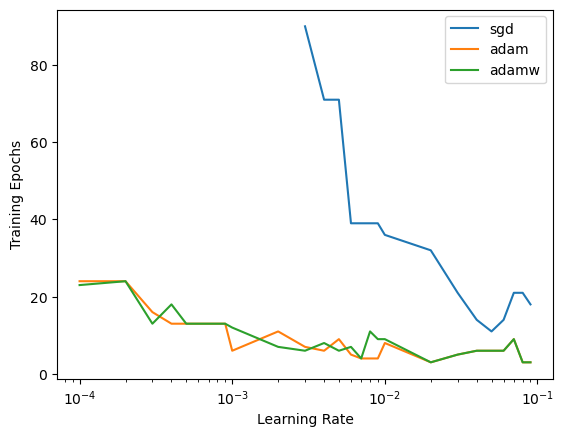

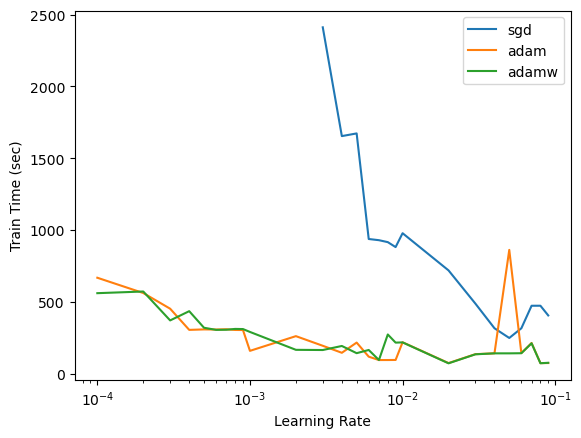

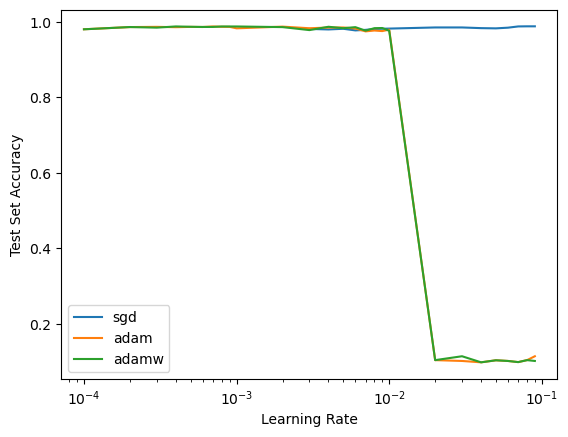

In [659]:
lrs = [1e-4, 2e-4, 3e-4, 4e-4, 5e-4, 6e-4, 7e-4, 8e-4, 9e-4, 1e-3, 2e-3, 3e-3, 4e-3, 5e-3, 6e-3, 7e-3, 8e-3, 9e-3, 1e-2, 2e-2, 3e-2, 4e-2, 5e-2, 6e-2, 7e-2, 8e-2, 9e-2]
sgd_lrs = [3e-3, 4e-3, 5e-3, 6e-3, 7e-3, 8e-3, 9e-3, 1e-2, 2e-2, 3e-2, 4e-2, 5e-2, 6e-2, 7e-2, 8e-2, 9e-2]
epochs = {"sgd": [], "adam": [], "adamw": []}
train_time = {"sgd": [], "adam": [], "adamw": []}
test_acc = {"sgd": [], "adam": [], "adamw": []}

for _lr in lrs:
    for _optimizer in ["sgd", "adam", "adamw"]:
        _framework = "torch"  #@param ["torch", "jax"]
        _val_split = 0.1  #@param
        _rotation_degrees = 0  #@param
        _crop_padding = 0  #@param
        _duplicate_with_augment = False  # Adds --duplicate_with_augment flag
        _init = "kaiming"  #@param ["orthogonal", "kaiming", "xavier"]
        #_optimizer = "adamw"  #@param ["sgd", "adam", "adamw"]
        _activation = "relu"  #@param ["relu", "tanh", "sigmoid"]
        #_lr = 3e-4  #@param
        _seed = SEED  #@param
        
        model_name = f'src/models/ckpts/lenet_{_framework}_{_val_split}_{_rotation_degrees}_{_crop_padding}_{_duplicate_with_augment}_{_init}_{_optimizer}_{_activation}_{_lr}_{_seed}'
        data_path = model_name + '.json'
    
        # Load json
        if os.path.exists(data_path):
            with open(data_path, 'r') as file:
                data = json.load(file)
                #print(_lr, data)
                epochs[_optimizer].append(data["epochs"])
                train_time[_optimizer].append(data["train_time"])
                test_acc[_optimizer].append(data["test_accuracy"])

plt.plot(sgd_lrs, epochs["sgd"], label="sgd"); plt.plot(lrs, epochs["adam"], label="adam"); plt.plot(lrs, epochs["adamw"], label="adamw"); plt.legend(); plt.ylabel("Training Epochs"); plt.xlabel("Learning Rate"); plt.xscale('log'); plt.show()
plt.plot(sgd_lrs, train_time["sgd"], label="sgd"); plt.plot(lrs, train_time["adam"], label="adam"); plt.plot(lrs, train_time["adamw"], label="adamw"); plt.legend(); plt.ylabel("Train Time (sec)"); plt.xlabel("Learning Rate"); plt.xscale('log'); plt.show()
plt.plot(sgd_lrs, test_acc["sgd"], label="sgd"); plt.plot(lrs, test_acc["adam"], label="adam"); plt.plot(lrs, test_acc["adamw"], label="adamw"); plt.legend(); plt.ylabel("Test Set Accuracy"); plt.xlabel("Learning Rate"); plt.xscale('log'); plt.show()

#### Activation Function

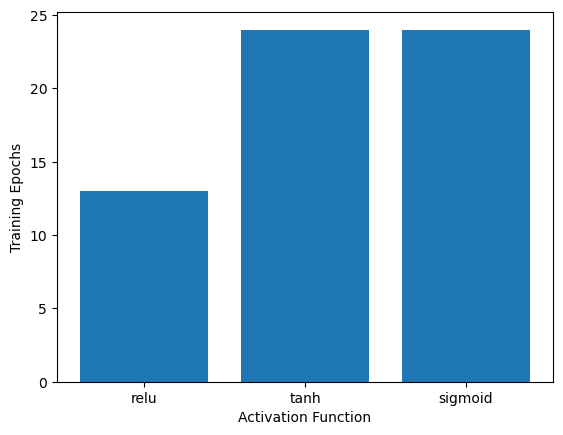

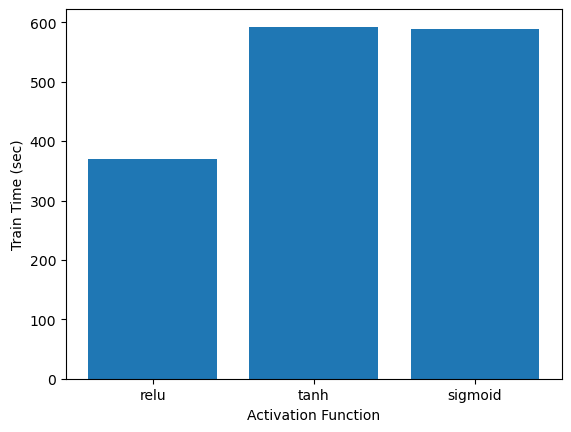

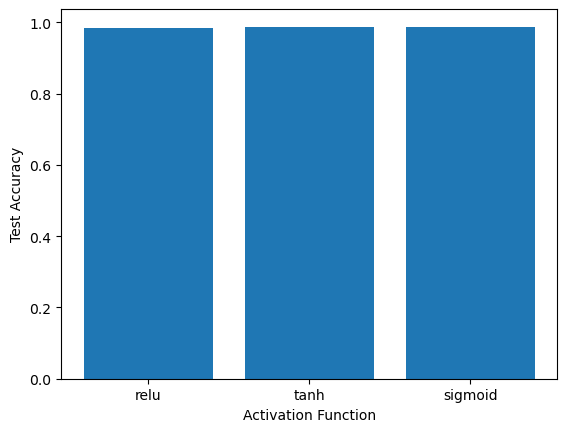

In [670]:
activations = ["relu", "tanh", "sigmoid"]

epochs = []
train_time = []
test_acc = []

for _activation in activations:
    _framework = "torch"  #@param ["torch", "jax"]
    _val_split = 0.1  #@param
    _rotation_degrees = 0  #@param
    _crop_padding = 0  #@param
    _duplicate_with_augment = False  # Adds --duplicate_with_augment flag
    _init = "kaiming"  #@param ["orthogonal", "kaiming", "xavier"]
    _optimizer = "adamw"  #@param ["sgd", "adam", "adamw"]
    #_activation = "relu"  #@param ["relu", "tanh", "sigmoid"]
    _lr = 3e-4  #@param
    _seed = SEED  #@param
    
    model_name = f'src/models/ckpts/lenet_{_framework}_{_val_split}_{_rotation_degrees}_{_crop_padding}_{_duplicate_with_augment}_{_init}_{_optimizer}_{_activation}_{_lr}_{_seed}'
    data_path = model_name + '.json'

    # Load json
    if os.path.exists(data_path):
        with open(data_path, 'r') as file:
            data = json.load(file)
            #print(_lr, data)
            epochs.append(data["epochs"])
            train_time.append(data["train_time"])
            test_acc.append(data["test_accuracy"])

plt.bar(activations, epochs); plt.ylabel("Training Epochs"); plt.xlabel("Activation Function"); plt.show()
plt.bar(activations, train_time); plt.ylabel("Train Time (sec)"); plt.xlabel("Activation Function"); plt.show()
plt.bar(activations, test_acc); plt.ylabel("Test Accuracy"); plt.xlabel("Activation Function"); plt.show()

#### Padding

0 True {'epochs': 19, 'train_time': 452.13560461997986, 'test_accuracy': 0.9865}
0 False {'epochs': 13, 'train_time': 370.67990612983704, 'test_accuracy': 0.9848}
1 True {'epochs': 18, 'train_time': 825.716644525528, 'test_accuracy': 0.9873}
1 False {'epochs': 22, 'train_time': 525.7688174247742, 'test_accuracy': 0.9886}
2 True {'epochs': 13, 'train_time': 609.0922276973724, 'test_accuracy': 0.9826}
2 False {'epochs': 22, 'train_time': 539.7228739261627, 'test_accuracy': 0.9859}
3 True {'epochs': 17, 'train_time': 2622.350285768509, 'test_accuracy': 0.9856}
3 False {'epochs': 24, 'train_time': 579.166446685791, 'test_accuracy': 0.9832}
4 True {'epochs': 22, 'train_time': 1870.2814664840698, 'test_accuracy': 0.9845}
4 False {'epochs': 23, 'train_time': 563.1776831150055, 'test_accuracy': 0.9795}
5 True {'epochs': 12, 'train_time': 550.3082158565521, 'test_accuracy': 0.9749}
5 False {'epochs': 17, 'train_time': 411.9127562046051, 'test_accuracy': 0.9708}


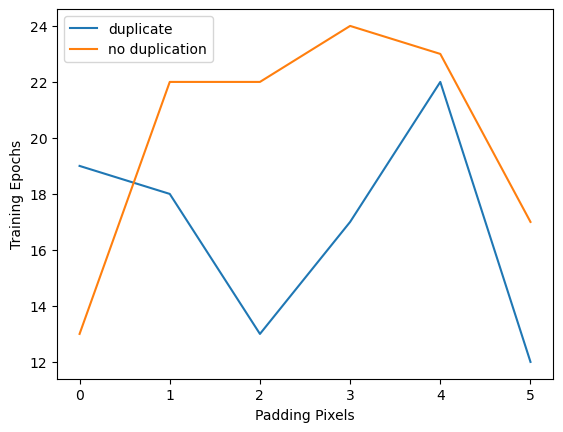

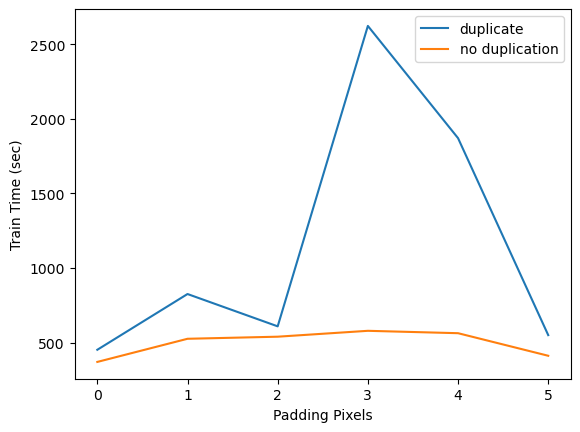

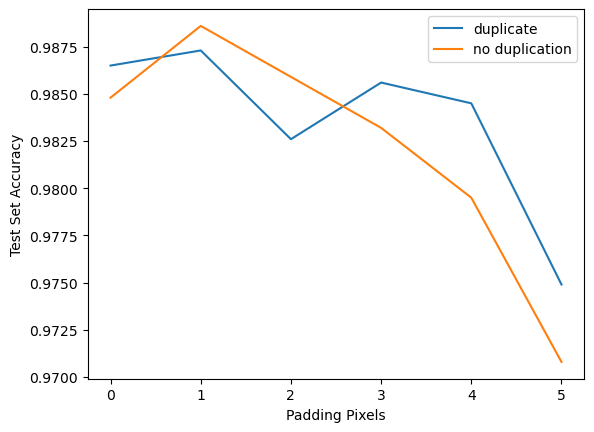

In [631]:
padding = range(0,6)
epochs = {True: [], False: []}
train_time = {True: [], False: []}
test_acc = {True: [], False: []}

for _crop_padding in range(0,6):
    for _duplicate_with_augment in [True, False]:
        _framework = "torch"  #@param ["torch", "jax"]
        _val_split = 0.1  #@param
        _rotation_degrees = 0  #@param
        #_crop_padding = 0  #@param
        #_duplicate_with_augment = False  # Adds --duplicate_with_augment flag
        _init = "kaiming"  #@param ["orthogonal", "kaiming", "xavier"]
        _optimizer = "adamw"  #@param ["sgd", "adam", "adamw"]
        _activation = "relu"  #@param ["relu", "tanh", "sigmoid"]
        _lr = 3e-4  #@param
        _seed = SEED  #@param
        
        
        model_name = f'src/models/ckpts/lenet_{_framework}_{_val_split}_{_rotation_degrees}_{_crop_padding}_{_duplicate_with_augment}_{_init}_{_optimizer}_{_activation}_{_lr}_{_seed}'
        data_path = model_name + '.json'

        # Load json
        with open(data_path, 'r') as file:
            data = json.load(file)
            print(_crop_padding, _duplicate_with_augment, data)
            epochs[_duplicate_with_augment].append(data["epochs"])
            train_time[_duplicate_with_augment].append(data["train_time"])
            test_acc[_duplicate_with_augment].append(data["test_accuracy"])

plt.plot(padding, epochs[True], label="duplicate"); plt.plot(padding, epochs[False], label="no duplication"); plt.legend(); plt.ylabel("Training Epochs"); plt.xlabel("Padding Pixels"); plt.show()
plt.plot(padding, train_time[True], label="duplicate"); plt.plot(padding, train_time[False], label="no duplication"); plt.legend(); plt.ylabel("Train Time (sec)"); plt.xlabel("Padding Pixels"); plt.show()
plt.plot(padding, test_acc[True], label="duplicate"); plt.plot(padding, test_acc[False], label="no duplication"); plt.legend(); plt.ylabel("Test Set Accuracy"); plt.xlabel("Padding Pixels"); plt.show()

#### Rotation

0 True {'epochs': 19, 'train_time': 452.13560461997986, 'test_accuracy': 0.9865}
0 False {'epochs': 13, 'train_time': 370.67990612983704, 'test_accuracy': 0.9848}
1 True {'epochs': 24, 'train_time': 1141.5680136680603, 'test_accuracy': 0.9879}
1 False {'epochs': 19, 'train_time': 468.554749250412, 'test_accuracy': 0.9865}
2 True {'epochs': 24, 'train_time': 1127.7345957756042, 'test_accuracy': 0.9879}
2 False {'epochs': 19, 'train_time': 472.9605059623718, 'test_accuracy': 0.9865}
3 True {'epochs': 12, 'train_time': 576.5167379379272, 'test_accuracy': 0.9844}
3 False {'epochs': 23, 'train_time': 578.3661458492279, 'test_accuracy': 0.987}
4 True {'epochs': 19, 'train_time': 900.7171618938446, 'test_accuracy': 0.9857}
4 False {'epochs': 18, 'train_time': 445.7014694213867, 'test_accuracy': 0.9864}
5 True {'epochs': 19, 'train_time': 886.7960202693939, 'test_accuracy': 0.9869}
5 False {'epochs': 13, 'train_time': 308.02598547935486, 'test_accuracy': 0.9842}
6 True {'epochs': 24, 'train_ti

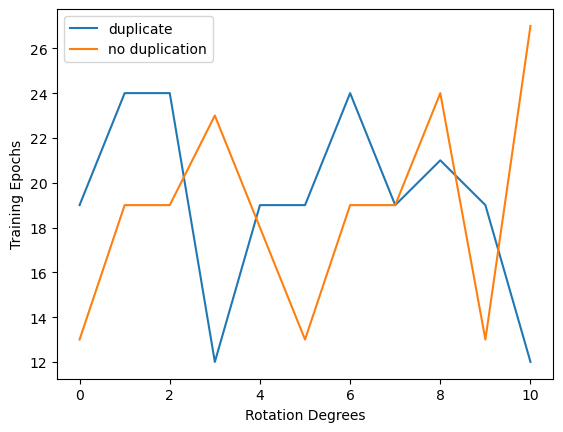

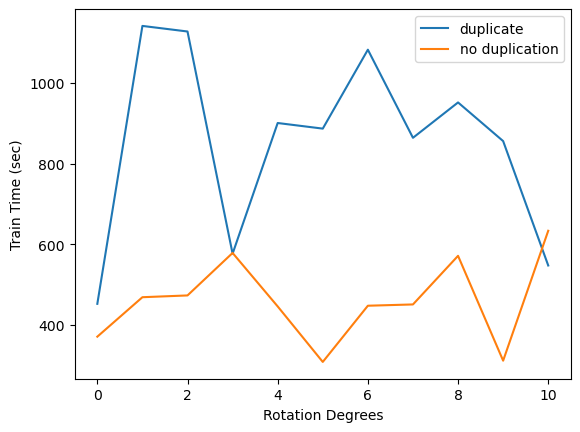

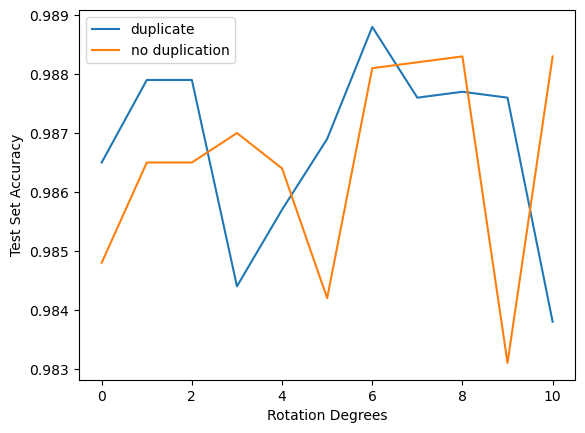

In [630]:
rotation = range(0,11)
epochs = {True: [], False: []}
train_time = {True: [], False: []}
test_acc = {True: [], False: []}

for _rotation_degrees in range(0,11):
    for _duplicate_with_augment in [True, False]:
        _framework = "torch"  #@param ["torch", "jax"]
        _val_split = 0.1  #@param
        #_rotation_degrees = 0  #@param
        _crop_padding = 0  #@param
        #_duplicate_with_augment = False  # Adds --duplicate_with_augment flag
        _init = "kaiming"  #@param ["orthogonal", "kaiming", "xavier"]
        _optimizer = "adamw"  #@param ["sgd", "adam", "adamw"]
        _activation = "relu"  #@param ["relu", "tanh", "sigmoid"]
        _lr = 3e-4  #@param
        _seed = SEED  #@param
        
        
        model_name = f'src/models/ckpts/lenet_{_framework}_{_val_split}_{_rotation_degrees}_{_crop_padding}_{_duplicate_with_augment}_{_init}_{_optimizer}_{_activation}_{_lr}_{_seed}'
        data_path = model_name + '.json'

        # Load json
        with open(data_path, 'r') as file:
            data = json.load(file)
            print(_rotation_degrees, _duplicate_with_augment, data)
            epochs[_duplicate_with_augment].append(data["epochs"])
            train_time[_duplicate_with_augment].append(data["train_time"])
            test_acc[_duplicate_with_augment].append(data["test_accuracy"])

plt.plot(rotation, epochs[True], label="duplicate"); plt.plot(rotation, epochs[False], label="no duplication"); plt.legend(); plt.ylabel("Training Epochs"); plt.xlabel("Rotation Degrees"); plt.show()
plt.plot(rotation, train_time[True], label="duplicate"); plt.plot(rotation, train_time[False], label="no duplication"); plt.legend(); plt.ylabel("Train Time (sec)"); plt.xlabel("Rotation Degrees"); plt.show()
plt.plot(rotation, test_acc[True], label="duplicate"); plt.plot(rotation, test_acc[False], label="no duplication"); plt.legend(); plt.ylabel("Test Set Accuracy"); plt.xlabel("Rotation Degrees"); plt.show()

#### Random Seed

Some interesting ideas on random seeds and variation in NNs:
- https://x.com/kellerjordan0/status/1646572378292629504
- https://arxiv.org/pdf/2304.01910

### Interpretability

In [586]:
import src.misc.interp as interp

importlib.reload(interp)

<module 'src.misc.interp' from '/Users/nicholascarolan/lenet-5/src/misc/interp.py'>

#### Saliency Maps

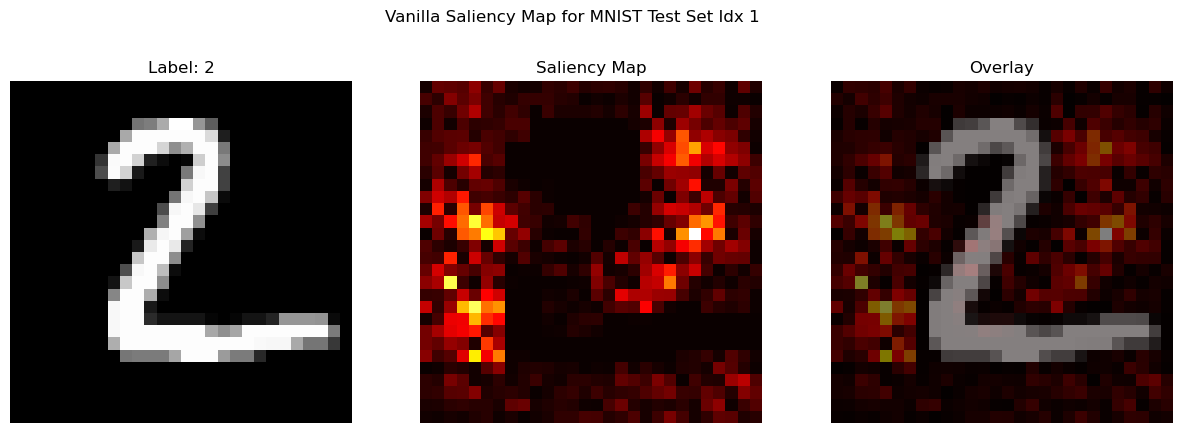

In [587]:
test_idx = 1  #@param

x, y = test_x[test_idx], test_y[test_idx]

sal = interp.saliency_map(lenet5, x, y)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
plt.suptitle(f'Vanilla Saliency Map for MNIST Test Set Idx {test_idx}')
ax[0].imshow(x.squeeze(), cmap="gray"); ax[0].set_title(f'Label: {y}'); ax[0].axis("off");
ax[1].imshow(sal.numpy(), cmap="hot"); ax[1].set_title(f'Saliency Map'); ax[1].axis("off");
ax[2].imshow(x.squeeze(), cmap="gray"); ax[2].imshow(sal.numpy(), cmap="hot", alpha=0.5); ax[2].set_title("Overlay"); ax[2].axis("off"); plt.show()

Notice how the digit pixels have the lowest gradient.
In an attempt to highlight which parts of the writing contribute to the class, we can visualize Gradient × Input.

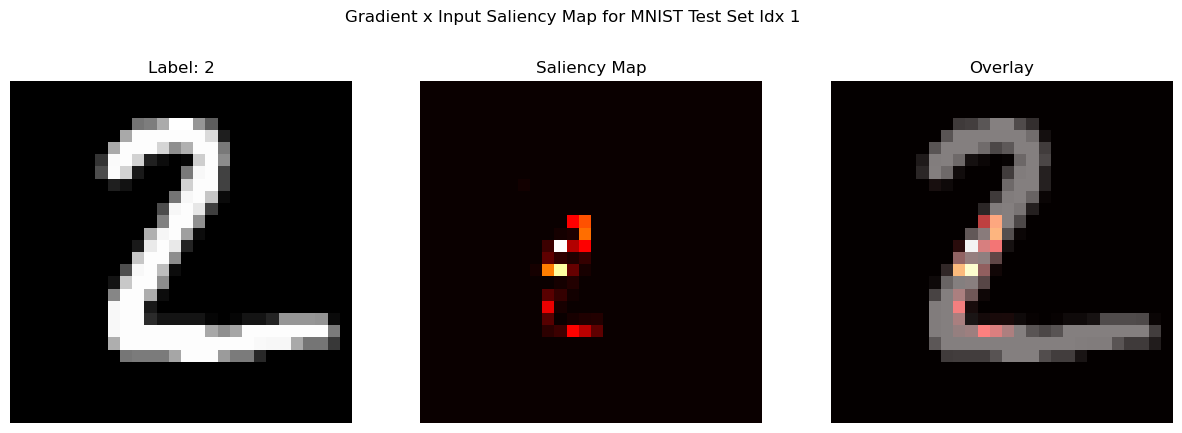

In [590]:
inp_sal = interp.saliency_map(lenet5, x, y, grad_times_input=True)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
plt.suptitle(f'Gradient x Input Saliency Map for MNIST Test Set Idx {test_idx}')
ax[0].imshow(x.squeeze(), cmap="gray"); ax[0].set_title(f'Label: {y}'); ax[0].axis("off");
ax[1].imshow(inp_sal.numpy(), cmap="hot"); ax[1].set_title(f'Saliency Map'); ax[1].axis("off");
ax[2].imshow(x.squeeze(), cmap="gray"); ax[2].imshow(inp_sal.numpy(), cmap="hot", alpha=0.5); ax[2].set_title("Overlay"); ax[2].axis("off"); plt.show()

#### Grad-CAM

In [435]:
print(lenet5)  # Check layer names. These can be the target_layer for GradCAM, e.g. target_layer=lenet5.pool2

TorchLeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (act_fn): ReLU()
)


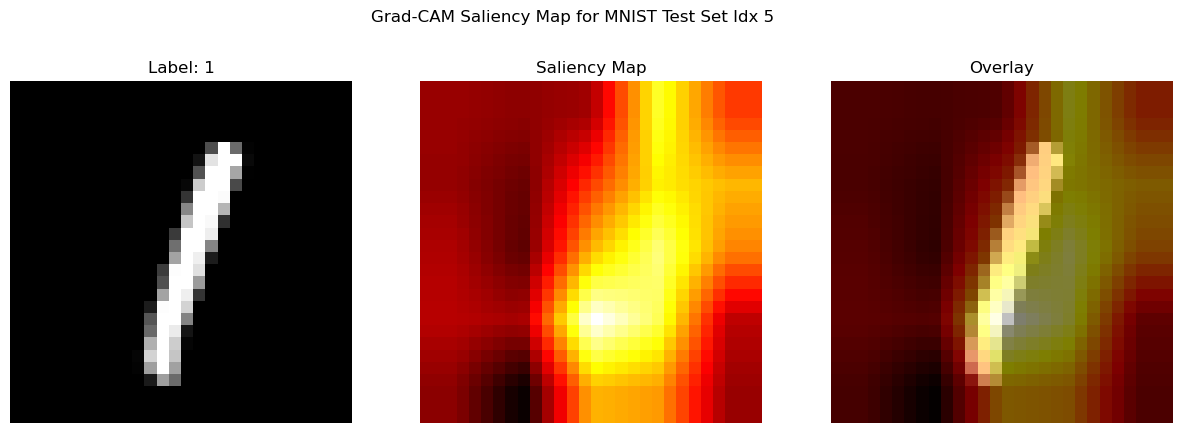

In [780]:
test_idx = 5  #@param

x, y = test_x[test_idx], test_y[test_idx]

vis = grad_cam(
    model=lenet5,
    input_tensor=x,
    target_layer=lenet5.pool2,
    target_class=y,
    normalize=True,)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
plt.suptitle(f'Grad-CAM Saliency Map for MNIST Test Set Idx {test_idx}')
ax[0].imshow(x.squeeze(), cmap="grey"); ax[0].set_title(f'Label: {y}'); ax[0].axis("off");
ax[1].imshow(vis.numpy().squeeze(), cmap="hot"); ax[1].set_title(f'Saliency Map'); ax[1].axis("off");
ax[2].imshow(x.squeeze(), cmap="gray"); ax[2].imshow(vis.numpy().squeeze(), cmap="hot", alpha=0.5); ax[2].set_title("Overlay"); ax[2].axis("off"); plt.show()

#### Linear Probes and Sparse Autoencoders (SAEs)

In [836]:
# Record activations from many forward passes in the network. 
# Then train an autoencoder to learn some sparse feature set from the activations at a chosen layer, probably fc1?

train_dataset, test_dataset, val_dataset = data.get_MNIST()
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)
test_x, test_y = next(iter(test_loader))   # apply transforms (normalization)
test_x, test_y = test_x.to(device), test_y.to(device)

layer_to_hook = getattr(lenet5, 'fc1')  # Choose a layer to record activations

activations = []  # (batches x batch_size x neurons)

def hook(model, input, output):
    activations.append(output.detach())

hook_handle = layer_to_hook.register_forward_hook(hook)

# Run inference
lenet5.eval()
with torch.no_grad():
    _logits = lenet5(test_x)

hook_handle.remove()

activations = activations[0].detach().cpu().numpy()
print(activations.shape)

(10000, 120)


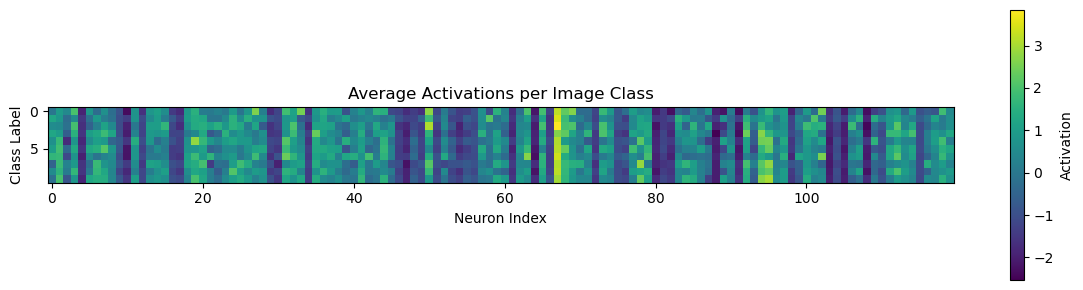

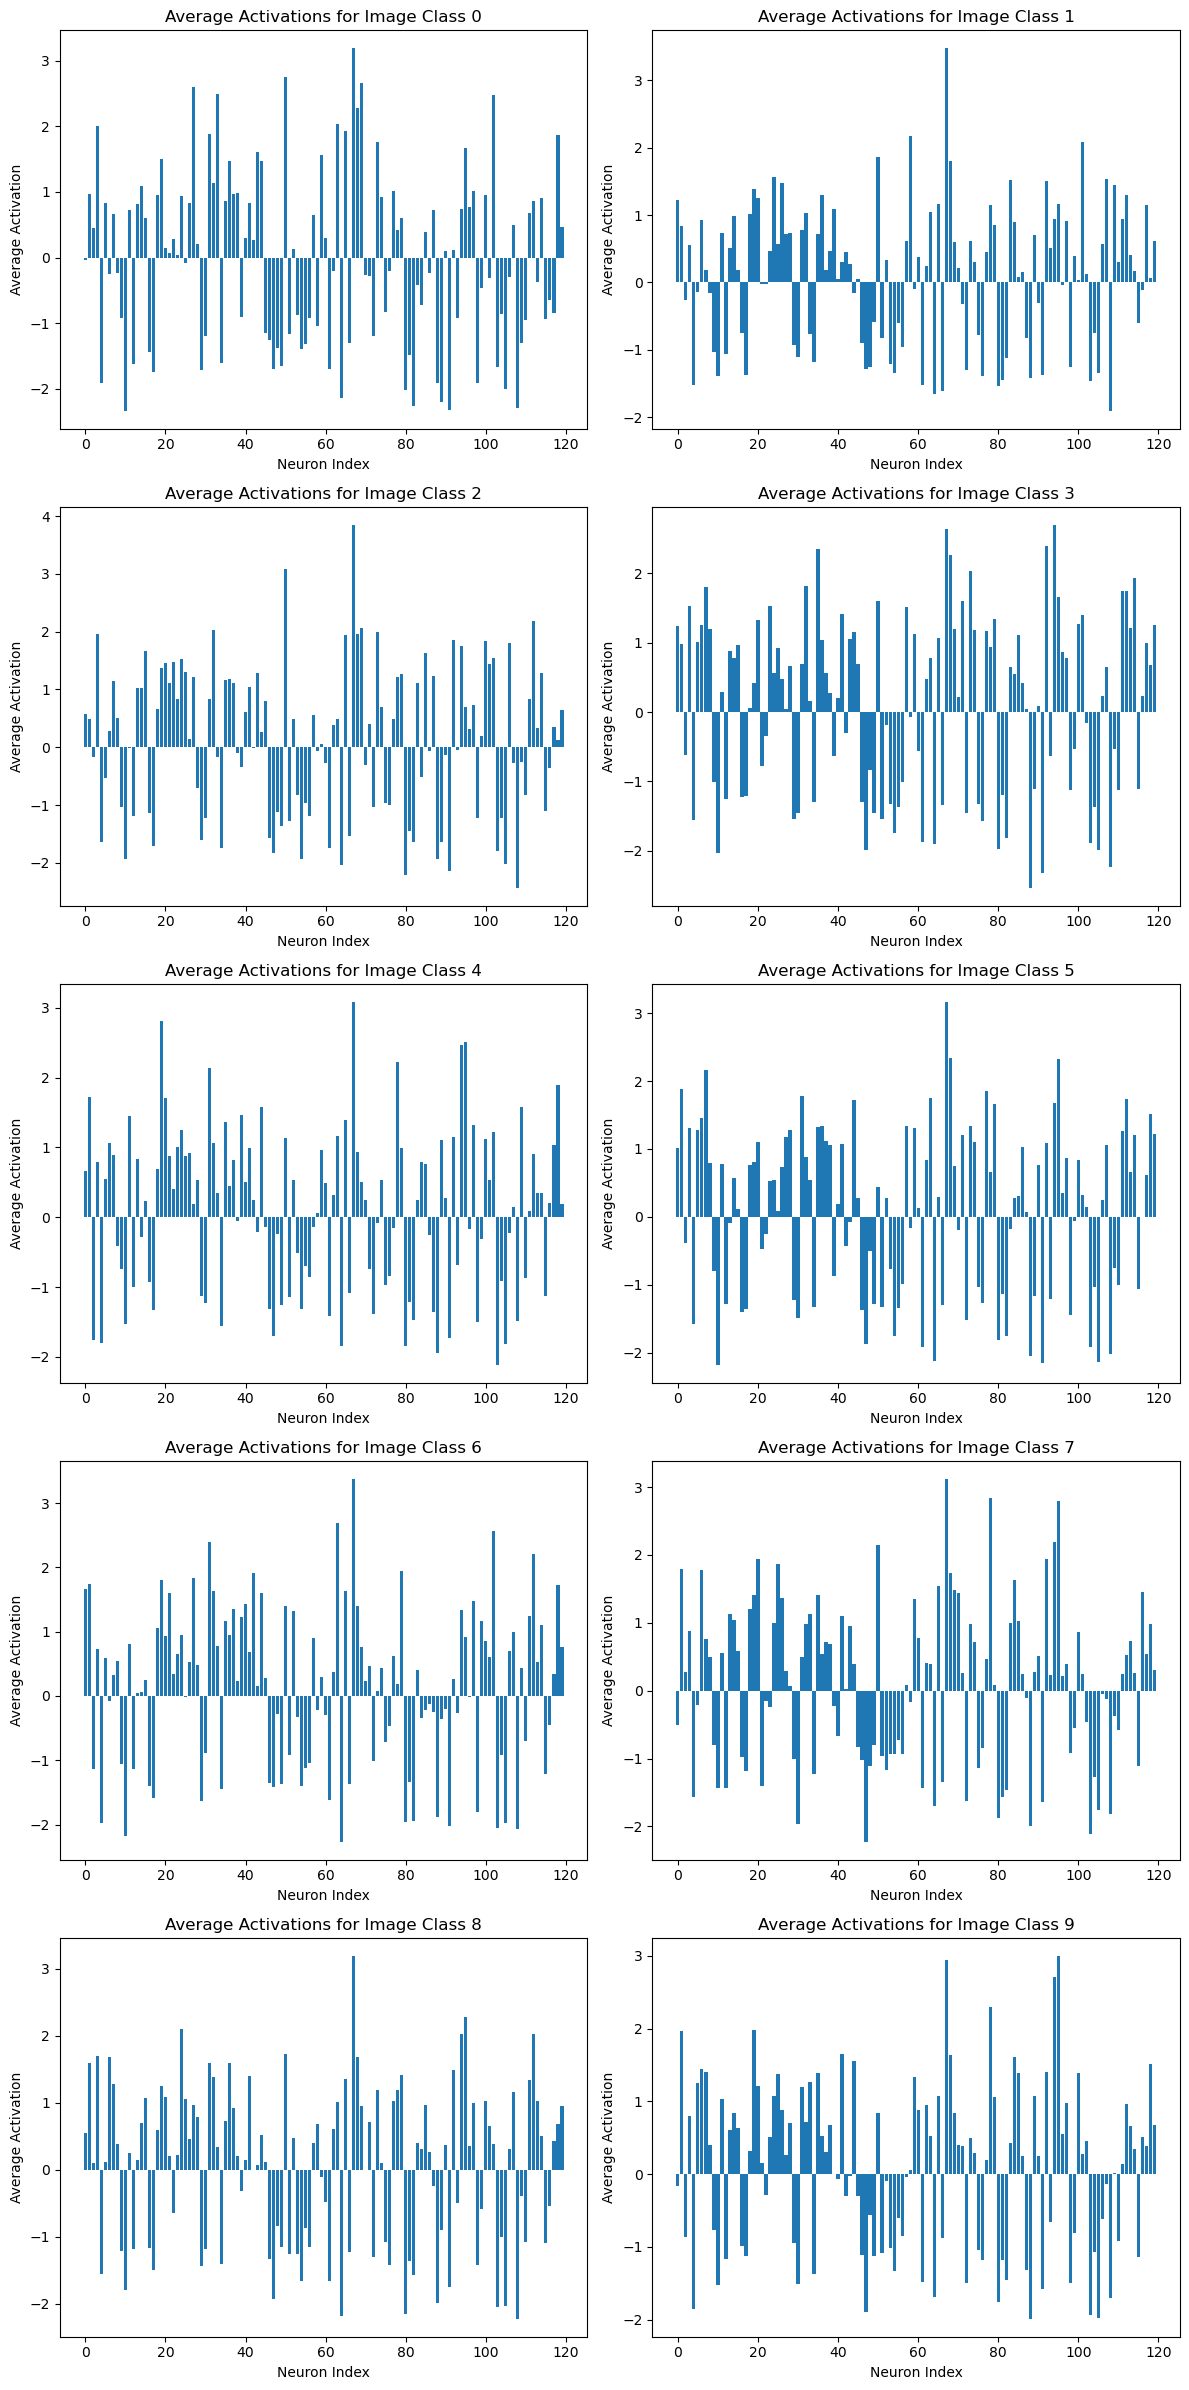

In [839]:
# Start by considering each neuron as interpretable

# Compute mean activation in each neuron for each class label
avg_activations = np.zeros((10, activations.shape[1]))
for label in range(10):
    avg_activations[label] = activations[test_y == label].mean(axis=0)

plt.figure(figsize=(12, 3)); plt.imshow(avg_activations); plt.colorbar(label='Activation'); plt.xlabel('Neuron Index'); plt.ylabel('Class Label'); plt.title(f"Average Activations per Image Class"); plt.tight_layout(); plt.show();

fig, axes = plt.subplots(5, 2, figsize=(12,24))
axes = axes.flatten()
for label in range(10):
    axes[label].bar(np.arange(activations.shape[1]), avg_activations[label]); axes[label].set_xlabel("Neuron Index"); axes[label].set_ylabel("Average Activation"); axes[label].set_title(f"Average Activations for Image Class {label}"); 
plt.tight_layout(); plt.show();

At the last fully connected layer, this is a trivial exercise, as the activations are just the class logits. At prior MLP layers, the relationships between individual neurons and classes are much less obvious.

In [ ]:
# Then compare to multi-neuron learned features

### Adversarial Examples

In [763]:
import src.misc.adversarial as adversarial

importlib.reload(adversarial)

<module 'src.misc.adversarial' from '/Users/nicholascarolan/lenet-5/src/misc/adversarial.py'>

In [764]:
_train_dataset, test_dataset, _val_dataset = data.get_MNIST()

MNIST_TRAIN_MEAN = test_dataset.data.float().mean()
MNIST_TRAIN_STD = test_dataset.data.float().std()
MNIST_DIM = 255

def mnist_normalize(x):
    """Normalize MNIST tensor to zero-mean, unit-std scale."""
    return (x - MNIST_TRAIN_MEAN) / MNIST_TRAIN_STD

def mnist_denormalize(x):
    """Reverse normalization back to pixel scale."""
    x =  x * MNIST_TRAIN_STD + MNIST_TRAIN_MEAN
    return torch.clamp(x, 0, MNIST_DIM)

#### Fast Gradient Sign Method

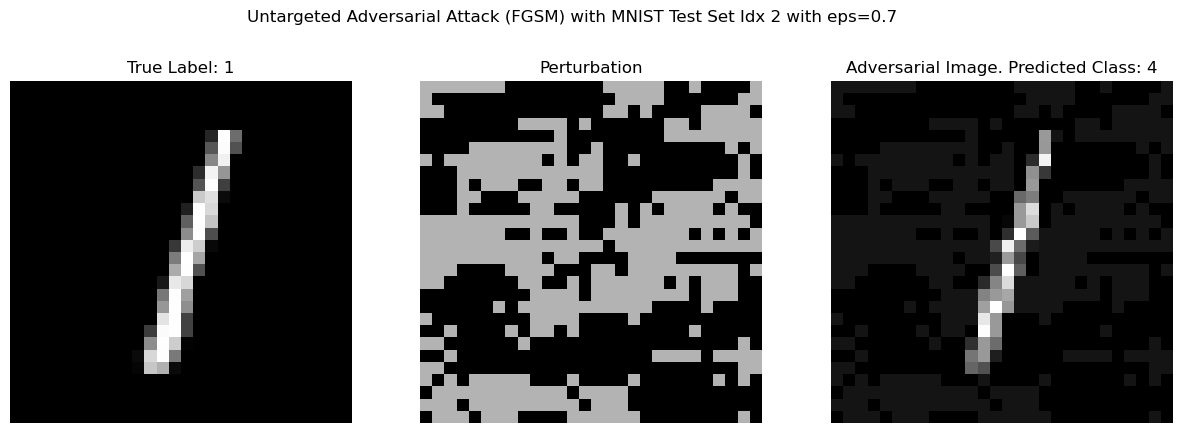

Labels:             0      1      2      3      4      5      6      7      8      9
Original Logits: -2.22   9.59  -2.38  -7.14  -0.07  -6.55  -2.38  -0.69  -1.46  -5.73
Attack Logits:   -4.47   0.58  -1.57  -1.93   2.33  -2.94  -4.41   2.00   1.17  -2.71
Magnitude of Perturbation: L1=437.98, L2=16.14


In [769]:
test_idx = 2  #@param
epsilon = 0.7
x, y = test_x[test_idx], test_y[test_idx]

attack_img, perturbation = adversarial.fgsm(lenet5, x, y, epsilon=epsilon)
attack_logits = lenet5(attack_img)
y_pred = int(attack_logits.argmax(axis=1))

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
plt.suptitle(f'Untargeted Adversarial Attack (FGSM) with MNIST Test Set Idx {test_idx} with eps={epsilon}')
ax[0].imshow(x.squeeze(), cmap='grey'); ax[0].set_title(f'True Label: {y}'); ax[0].axis("off")
ax[1].imshow(perturbation.squeeze(), cmap='grey', vmin=0, vmax=1); ax[1].set_title(f'Perturbation'); ax[1].axis("off")
ax[2].imshow(attack_img.squeeze(), cmap='grey'); ax[2].set_title(f'Adversarial Image. Predicted Class: {y_pred}'); ax[2].axis("off"); plt.show()

# Compare logits before and after attack
attack_logits = attack_logits.squeeze().tolist()
real_logits = lenet5(x.unsqueeze(0)).squeeze().tolist()
labels = [i for i in range(10)]
print("Labels:        " + " ".join(f"{i:6d}" for i in labels))
print("Original Logits:" + " ".join(f"{x:6.2f}" for x in real_logits))
print("Attack Logits:  " + " ".join(f"{x:6.2f}" for x in attack_logits))

l1, l2 = adversarial.l1_distance_torch(x, attack_img), adversarial.l2_distance_torch(x, attack_img)
print(f'Magnitude of Perturbation: L1={l1:.2f}, L2={l2:.2f}')

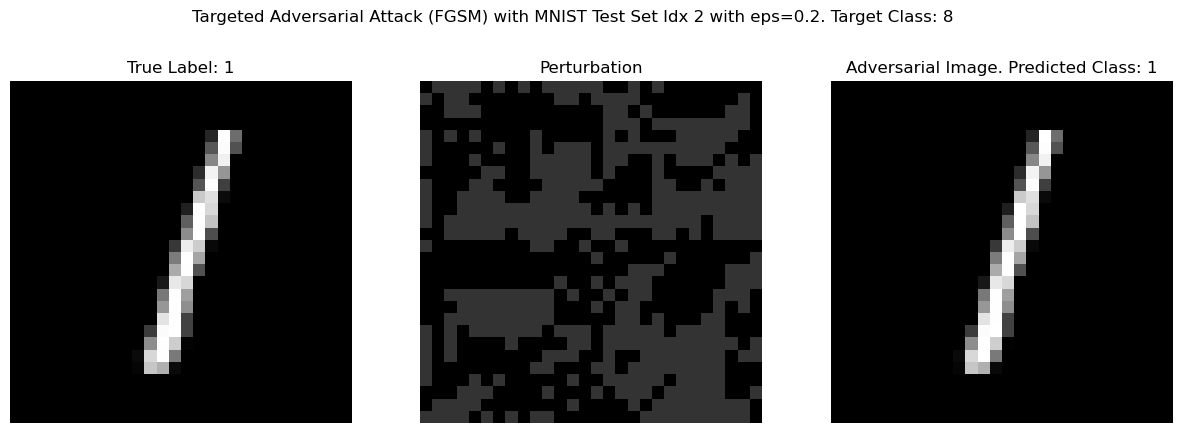

Labels:             0      1      2      3      4      5      6      7      8      9
Original Logits: -1.70   9.20   0.34  -4.81  -0.48  -6.10  -2.48  -1.30   0.38  -7.25
Attack Logits:   -2.40   8.26   0.46  -3.01  -1.38  -4.54  -3.58  -1.74   2.04  -6.70
Magnitude of Perturbation: L1=84.00, L2=4.10


In [582]:
test_idx = 2  #@param
epsilon = 0.2
x, y = test_x[test_idx], test_y[test_idx]
y_target = 8

attack_img, perturbation = adversarial.fgsm_targeted(lenet5, x, y_target, epsilon=epsilon)
attack_logits = lenet5(attack_img)
y_pred = int(attack_logits.argmax(axis=1))

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
plt.suptitle(f'Targeted Adversarial Attack (FGSM) with MNIST Test Set Idx {test_idx} with eps={epsilon}. Target Class: {y_target}')
ax[0].imshow(x.squeeze(), cmap='grey'); ax[0].set_title(f'True Label: {y}'); ax[0].axis("off")
ax[1].imshow(perturbation.squeeze(), cmap='grey', vmin=0, vmax=1); ax[1].set_title(f'Perturbation'); ax[1].axis("off")
ax[2].imshow(attack_img.squeeze(), cmap='grey'); ax[2].set_title(f'Adversarial Image. Predicted Class: {y_pred}'); ax[2].axis("off"); plt.show()

# Compare logits before and after attack
attack_logits = attack_logits.squeeze().tolist()
real_logits = lenet5(x.unsqueeze(0)).squeeze().tolist()
labels = [i for i in range(10)]
print("Labels:        " + " ".join(f"{i:6d}" for i in labels))
print("Original Logits:" + " ".join(f"{x:6.2f}" for x in real_logits))
print("Attack Logits:  " + " ".join(f"{x:6.2f}" for x in attack_logits))

l1, l2 = adversarial.l1_distance_torch(x, attack_img), adversarial.l2_distance_torch(x, attack_img)
print(f'Magnitude of Perturbation: L1={l1:.2f}, L2={l2:.2f}')

#### Projected Gradient Descent

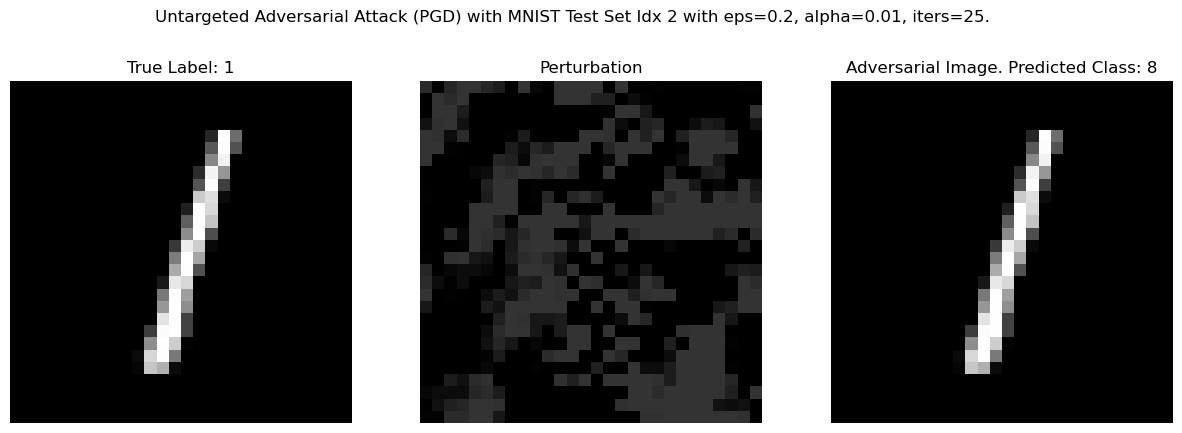

Labels:             0      1      2      3      4      5      6      7      8      9
Original Logits: -1.70   9.20   0.34  -4.81  -0.48  -6.10  -2.48  -1.30   0.38  -7.25
Attack Logits:   -1.69   4.02  -2.16  -3.58  -2.45  -3.81  -0.94  -3.76   4.80  -5.44
Magnitude of Perturbation: L1=118.23, L2=4.58


In [583]:
test_idx = 2  #@param
epsilon = 0.2
alpha = 1e-2
num_iter = 25
x, y = test_x[test_idx], test_y[test_idx]

attack_img, perturbation = adversarial.pgd(lenet5, x, epsilon, alpha, num_iter, y)
attack_logits = lenet5(attack_img)
y_pred = int(attack_logits.argmax(axis=1))

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
plt.suptitle(f'Untargeted Adversarial Attack (PGD) with MNIST Test Set Idx {test_idx} with eps={epsilon}, alpha={alpha}, iters={num_iter}.')
ax[0].imshow(x.squeeze(), cmap='grey'); ax[0].set_title(f'True Label: {y}'); ax[0].axis("off")
ax[1].imshow(perturbation.squeeze(), cmap='grey', vmin=0, vmax=1); ax[1].set_title(f'Perturbation'); ax[1].axis("off")
ax[2].imshow(attack_img.squeeze(), cmap='grey'); ax[2].set_title(f'Adversarial Image. Predicted Class: {y_pred}'); ax[2].axis("off"); plt.show()

# Compare logits before and after attack
attack_logits = attack_logits.squeeze().tolist()
real_logits = lenet5(x.unsqueeze(0)).squeeze().tolist()
labels = [i for i in range(10)]
print("Labels:        " + " ".join(f"{i:6d}" for i in labels))
print("Original Logits:" + " ".join(f"{x:6.2f}" for x in real_logits))
print("Attack Logits:  " + " ".join(f"{x:6.2f}" for x in attack_logits))

l1, l2 = adversarial.l1_distance_torch(x, attack_img), adversarial.l2_distance_torch(x, attack_img)
print(f'Magnitude of Perturbation: L1={l1:.2f}, L2={l2:.2f}')

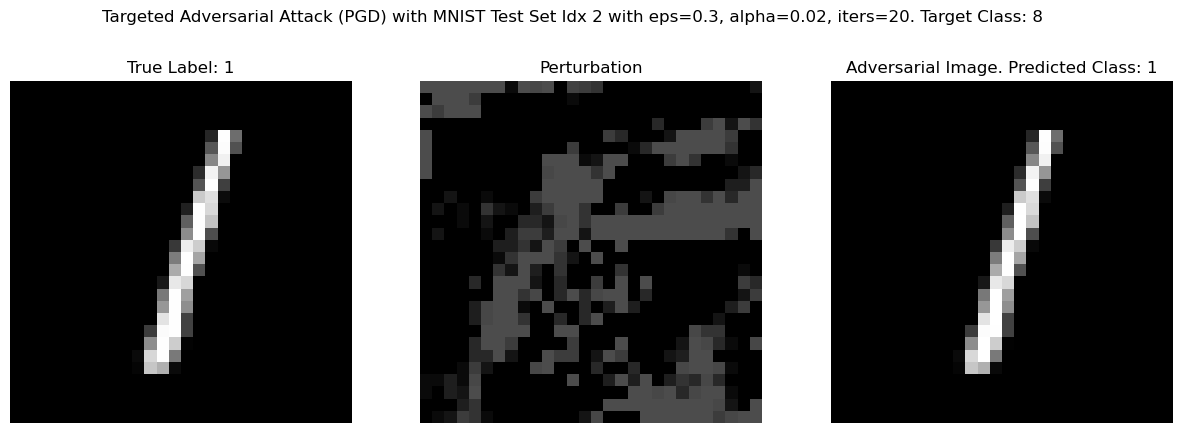

Labels:             0      1      2      3      4      5      6      7      8      9
Original Logits: -1.70   9.20   0.34  -4.81  -0.48  -6.10  -2.48  -1.30   0.38  -7.25
Attack Logits:   -1.43   6.36  -1.95  -5.37  -1.79  -4.23  -1.56  -3.40   3.96  -6.18
Magnitude of Perturbation: L1=85.52, L2=4.78


In [584]:
test_idx = 2  #@param
epsilon = 0.3
alpha = 2e-2
num_iter = 20
y_target = 8
x, y = test_x[test_idx], test_y[test_idx]

attack_img, perturbation = adversarial.pgd_targeted(lenet5, x, epsilon, alpha, num_iter, y_target)
attack_logits = lenet5(attack_img)
y_pred = int(attack_logits.argmax(axis=1))

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
plt.suptitle(f'Targeted Adversarial Attack (PGD) with MNIST Test Set Idx {test_idx} with eps={epsilon}, alpha={alpha}, iters={num_iter}. Target Class: {y_target}')
ax[0].imshow(x.squeeze(), cmap='grey'); ax[0].set_title(f'True Label: {y}'); ax[0].axis("off")
ax[1].imshow(perturbation.squeeze(), cmap='grey', vmin=0, vmax=1); ax[1].set_title(f'Perturbation'); ax[1].axis("off")
ax[2].imshow(attack_img.squeeze(), cmap='grey'); ax[2].set_title(f'Adversarial Image. Predicted Class: {y_pred}'); ax[2].axis("off"); plt.show()

# Compare logits before and after attack
attack_logits = attack_logits.squeeze().tolist()
real_logits = lenet5(x.unsqueeze(0)).squeeze().tolist()
labels = [i for i in range(10)]
print("Labels:        " + " ".join(f"{i:6d}" for i in labels))
print("Original Logits:" + " ".join(f"{x:6.2f}" for x in real_logits))
print("Attack Logits:  " + " ".join(f"{x:6.2f}" for x in attack_logits))

l1, l2 = adversarial.l1_distance_torch(x, attack_img), adversarial.l2_distance_torch(x, attack_img)
print(f'Magnitude of Perturbation: L1={l1:.2f}, L2={l2:.2f}')

#### Adversarial Training

We can try to reduce our model's vulnerability to adversarial examples by generating and including adversarial images during training.

In [772]:
_framework = "torch"  #@param ["torch", "jax"]
_val_split = 0.1  #@param
_rotation_degrees = 0  #@param
_crop_padding = 0  #@param
_duplicate_with_augment = False  # Adds --duplicate_with_augment flag
_init = "kaiming"  #@param ["orthogonal", "kaiming", "xavier"]
_optimizer = "adamw"  #@param ["sgd", "adam", "adamw"]
_activation = "relu"  #@param ["relu", "tanh", "sigmoid"]
_lr = 3e-4  #@param
_seed = SEED  #@param
_adversarial_training = True

! python src/train.py --framework={_framework} \
    --val_split={_val_split} \
    --rotation_degrees={_rotation_degrees} \
    --crop_padding={_crop_padding} \
    {"--duplicate_with_augment" if _duplicate_with_augment else ""} \
    --init={_init} \
    --optimizer={_optimizer} \
    --activation={_activation} \
    --lr={_lr} \
    --seed={_seed} \
    {"--adversarial_training" if _adversarial_training else ""}

---------------------------------------------
Framework:                  torch
Validation Split:           0.1
Rotation Degrees:           0
Crop Padding:               0
Duplicate with Augment:     False
Init method:                kaiming
Optimizer:                  adamw
Activation:                 relu
Learning Rate:              0.0003
Random Seed:                12
Adversarial Training:       True
---------------------------------------------
Train: Dataset MNIST
    Number of datapoints: 54000

Val: Dataset MNIST
    Number of datapoints: 6000
Test: Dataset MNIST
    Number of datapoints: 10000
    Root location: src/data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[tensor(0.1307)], std=[tensor(0.3081)])
           )

---------------------------------------------
TorchLeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dila

In [773]:
model_name = f'src/models/ckpts/lenet_{_framework}_{_val_split}_{_rotation_degrees}_{_crop_padding}_{_duplicate_with_augment}_{_init}_{_optimizer}_{_activation}_{_lr}_{_seed}_{_adversarial_training}'
model_path = model_name + '.pth'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
adv_lenet5 = TorchLeNet(act_fn=_activation, init=_init).to(device)
adv_lenet5.load_state_dict(torch.load(model_path))

print(f'Loaded model from {model_path}')

# Read training run metadata from JSON
with open(f'{model_name}.json', "r") as f:
    model_metadata = json.load(f)

print(f'Training run metadata: {model_metadata}')

Loaded model from src/models/ckpts/lenet_torch_0.1_0_0_False_kaiming_adamw_relu_0.0003_12_True.pth
Training run metadata: {'epochs': 13, 'train_time': 811.0231187343597, 'test_accuracy': 0.9787}


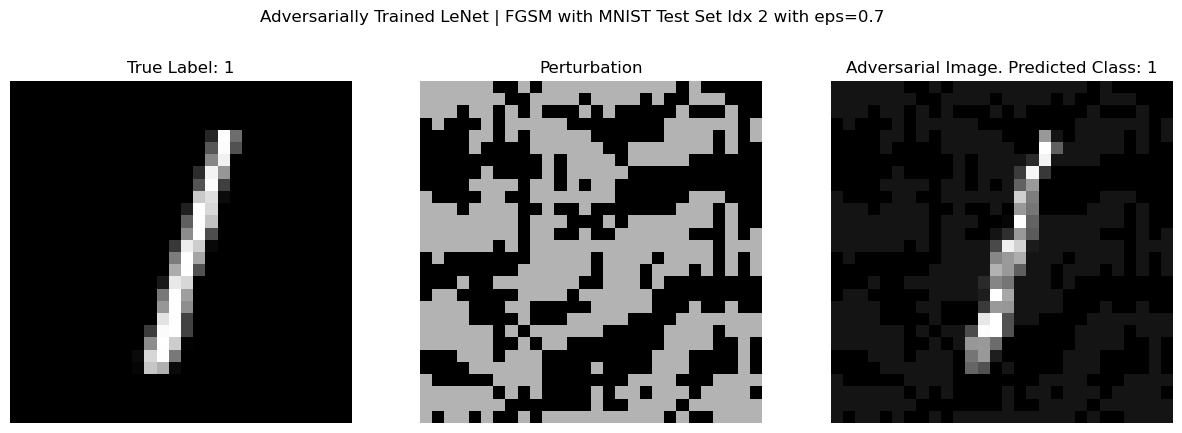

Labels:             0      1      2      3      4      5      6      7      8      9
Original Logits: -4.23   7.49  -1.91  -3.68  -0.46  -5.14  -1.28  -1.41  -2.40  -4.63
Attack Logits:   -4.47   6.49  -1.09  -2.39   5.05  -6.04   1.51  -0.71  -3.50  -1.21
Magnitude of Perturbation: L1=453.65, L2=16.67


In [774]:
# We can check if this adversarially trained model is more robust
test_idx = 2  #@param
epsilon = 0.7
x, y = test_x[test_idx], test_y[test_idx]

attack_img, perturbation = adversarial.fgsm(adv_lenet5, x, y, epsilon=epsilon)
attack_logits = adv_lenet5(attack_img)
y_pred = int(attack_logits.argmax(axis=1))

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
plt.suptitle(f'Adversarially Trained LeNet | FGSM with MNIST Test Set Idx {test_idx} with eps={epsilon}')
ax[0].imshow(x.squeeze(), cmap='grey'); ax[0].set_title(f'True Label: {y}'); ax[0].axis("off")
ax[1].imshow(perturbation.squeeze(), cmap='grey', vmin=0, vmax=1); ax[1].set_title(f'Perturbation'); ax[1].axis("off")
ax[2].imshow(attack_img.squeeze(), cmap='grey'); ax[2].set_title(f'Adversarial Image. Predicted Class: {y_pred}'); ax[2].axis("off"); plt.show()

# Compare logits before and after attack
attack_logits = attack_logits.squeeze().tolist()
real_logits = adv_lenet5(x.unsqueeze(0)).squeeze().tolist()
labels = [i for i in range(10)]
print("Labels:        " + " ".join(f"{i:6d}" for i in labels))
print("Original Logits:" + " ".join(f"{x:6.2f}" for x in real_logits))
print("Attack Logits:  " + " ".join(f"{x:6.2f}" for x in attack_logits))

l1, l2 = adversarial.l1_distance_torch(x, attack_img), adversarial.l2_distance_torch(x, attack_img)
print(f'Magnitude of Perturbation: L1={l1:.2f}, L2={l2:.2f}')

We can see that a FGSM attack of the same magnitude fools our baseline model (further above), but an adversarially trained model is more robust.

In [ ]:
# TODO: Compare magnitude of attack needed to switch prediction between the two models